# ARIMA Model For Downtown LA

**Reading Data File**

There are two datasets provided
1. **The LAbike dataset** had 639786 unique trip details with 13 attributes pertaining to start and end
station IDs with their co-ordinates, start and end times, pass holder type and trip category
whether one way or round trip.
2. **Stations_Table dataset** provides the details of each 143 stations with their unique Station IDs,
station names and their Go Live Date.

In [ ]:
#Importing reuired packages
import pandas as pd
import numpy as np

#LAbike dataset
df=pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/LABikeData.xlsx')
#Station_Table dataset
df2 = pd.read_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/Station_Table.xlsx')


Check for missing values

In [16]:
df2.isna().sum()

Station_ID      0
Station_Name    3
Go_live_date    3
Region          4
Status          3
dtype: int64

In [18]:
df.isna().sum()

trip_id                    0
bike_id                    0
start_station              0
end_station            43198
trip_route_category        0
start_time                 0
end_time                   0
start_lat               1354
start_lon               1354
end_lat                 9110
end_lon                 9110
plan_duration            384
passholder_type            0
dtype: int64

For our forecasting model we are only interested in number of trips so the missing values in other attributes does not affect our model performance and thus there is no need to deal with them.

In [19]:
#For some station Start latitude is zeroso removing it
df=df[df['start_lat']!=0]
df.describe()
df.columns
df.start_station.nunique()
df2.Station_ID.nunique()

143

Merging the two datasets on station id's

In [25]:
df3=df.set_index('start_station').join(df2.set_index('Station_ID'))


**Resampling**

We resampled the data to have number of trips on a particular day for every year

In [26]:
df4 = df3.loc[:,('start_time','Region', 'trip_id')]
df4['start_time'] = pd.to_datetime(df4.start_time, format = '%d/%m/%Y %I:%M:%S %p' )
df4
df4['Day'] = df4.start_time.dt.dayofweek
df4['Date'] = df4.start_time.dt.day
df4['Month'] = df4.start_time.dt.month
df4['Hour'] = df4.start_time.dt.hour
df4['Year'] = df4.start_time.dt.year
df4.groupby(['Day','Year'])['trip_id'].count()

Day  Year
0    2016    12909
     2017    30885
     2018    43745
1    2016    14296
     2017    32861
     2018    45127
2    2016    14480
     2017    33492
     2018    43563
3    2016    15230
     2017    33580
     2018    44024
4    2016    15256
     2017    34744
     2018    46019
5    2016    13498
     2017    32493
     2018    44546
6    2016    12936
     2017    31200
     2018    44870
Name: trip_id, dtype: int64

Converting our data in time series format which will then be used to fit ARIMA model

In [30]:
#DTLA DATA
Data_DTLA = df4.loc[df4['Region']=='DTLA',:]
Data_DTLA.index = Data_DTLA.start_time
Data_DTLA_D = Data_DTLA.resample('D').count()
Data_DTLA_D = Data_DTLA_D.rename(columns={'Region':'trips'})
Data_DTLA_D=Data_DTLA_D.drop(Data_DTLA_D.columns[[0,2,3,4,5,6,7]],axis=1)
Data_DTLA_D



,trips
start_time,
2016-07-07,190
2016-07-08,344
2016-07-09,421
2016-07-10,334
2016-07-11,349
2016-07-12,531
2016-07-13,534
2016-07-14,570
2016-07-15,484


**Data Partition**

Now let us have have a vsual representation of our data by dividing it into training and test data

Text(0, 0.5, 'Number of trips')

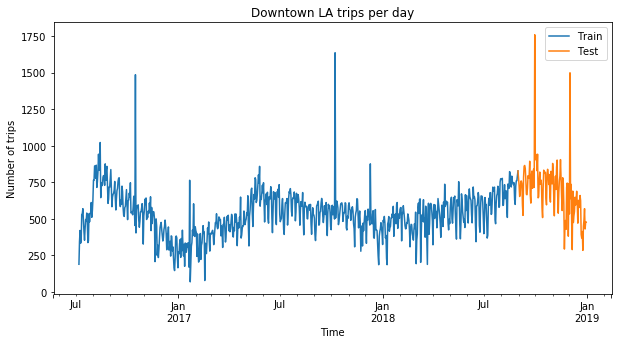

In [32]:
import matplotlib.pyplot as plt
train_DTLA = Data_DTLA_D.loc['2016-07-01':'2018-08-31']
test_DTLA = Data_DTLA_D.loc['2018-08-31':]
train_DTLA.shape,test_DTLA.shape
train_DTLA.trips.plot(label = 'Train')
test_DTLA.trips.plot(label="Test", figsize = (10,5))
plt.legend()
plt.title('Downtown LA trips per day')
plt.xlabel('Time')
plt.ylabel('Number of trips')


An ARIMA model is characterized by 3 terms: p, d, q
where,
p is the order of the AR term
q is the order of the MA term
d is the number of differencing required to make the time series stationary
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.
P, D & Q represents the same parameters ut for seasonal component.

Here we have used grid search method to iterate for various values of the parameters and checked the AIC value for each combination of parameters. The one which give lowest AIC value is the optimal combination of parameter which we used in fitting our model

In [33]:
import itertools
#Defining parameters p, d, q to take value from 0 to 2
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq=list(itertools.product(p,d,q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 28) for x in list(itertools.product(p, d, q))]


In [339]:
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore") # specify to ignore warning messages
arr=[]
min_aic = 1e64
for param in pdq:
 for param_seasonal in seasonal_pdq:
            mod = sm.tsa.statespace.SARIMAX(Data_DTLA_D,
                                            order=param,
                                            seasonal_order=param_seasonal, enforce_invertibility=False,
                                            enforce_stationarity=False
                                            )

            results = mod.fit()
            arr.append(results.aic)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                best_param,best_param_seasonal = param, param_seasonal

print(min(arr), 'ARIMA{}x{} - AIC:{}'.format(best_param, best_param_seasonal))
            
       

ARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:2525.05562210711
ARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:2297.0272757211105
ARIMA(0, 0, 0)x(0, 0, 2, 4) - AIC:2136.9057907497945
ARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:2044.4866348678174
ARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:1961.211272333069
ARIMA(0, 0, 0)x(0, 1, 2, 4) - AIC:1893.0551074077982
ARIMA(0, 0, 0)x(0, 2, 0, 4) - AIC:2044.4369708478393
ARIMA(0, 0, 0)x(0, 2, 1, 4) - AIC:1920.2125807114646
ARIMA(0, 0, 0)x(0, 2, 2, 4) - AIC:1848.033856867004
ARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:2085.790807659937
ARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:2045.2269250081545
ARIMA(0, 0, 0)x(1, 0, 2, 4) - AIC:1958.8699504778006
ARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:1976.551259533798
ARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:1963.2603332465444
ARIMA(0, 0, 0)x(1, 1, 2, 4) - AIC:1894.9863055393528
ARIMA(0, 0, 0)x(1, 2, 0, 4) - AIC:1942.7699510846
ARIMA(0, 0, 0)x(1, 2, 1, 4) - AIC:1919.9326191644523
ARIMA(0, 0, 0)x(1, 2, 2, 4) - AIC:1848.519967257789
ARIMA(0, 0, 0)x(2, 0, 0, 4) - AIC:1973.7189656842831
ARI

IndexError: tuple index out of range

The best model is obtained by choosing ARIMA(1,0,1)(1,2,2)28.


**Model Fitting**

In [34]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
mod = sm.tsa.statespace.SARIMAX(train_DTLA,
                                order=(1,0,1),
                                seasonal_order=(1, 2, 2,28),
                                enforce_invertibility=False,
                               enforce_stationarity=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\saksh\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7822      0.060     13.027      0.000       0.665       0.900
ma.L1         -0.2721      0.065     -4.217      0.000      -0.399      -0.146
ar.S.L28       0.0325      0.086      0.379      0.705      -0.136       0.201
ma.S.L28      -1.5331      0.300     -5.116      0.000      -2.120      -0.946
ma.S.L56       0.4739      0.238      1.990      0.047       0.007       0.941
sigma2      1.513e+04   3369.302      4.490      0.000    8523.284    2.17e+04


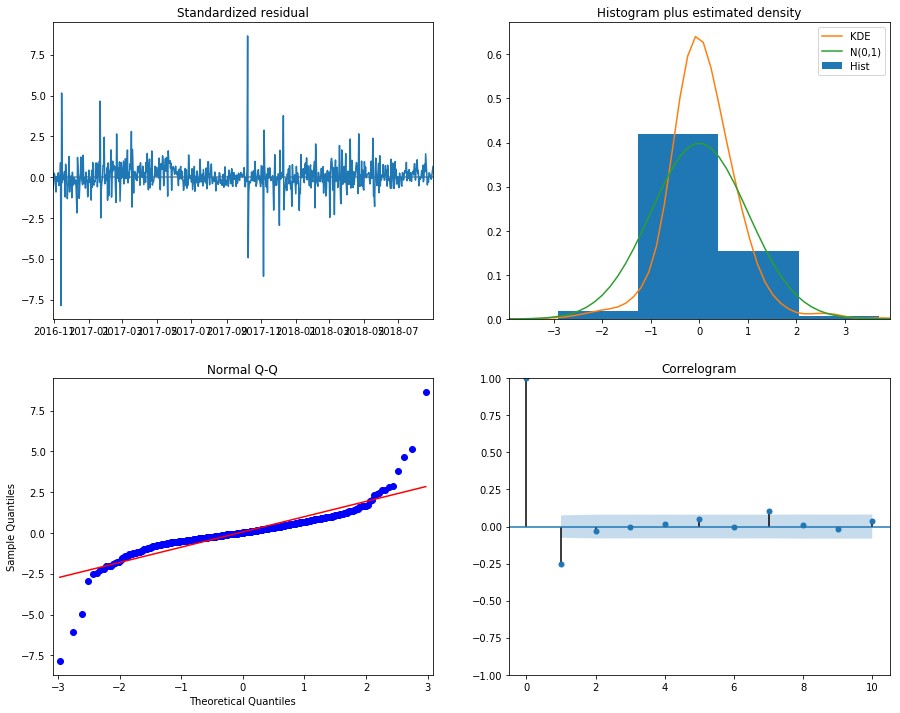

In [35]:
# Residual Diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Validation**

Now validating our model on test data.

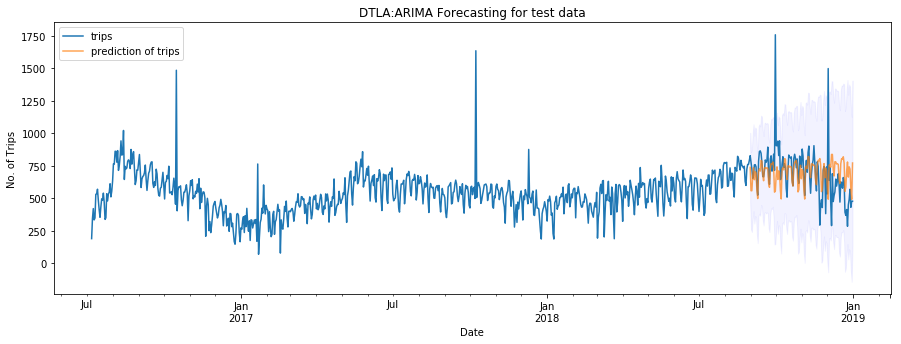

In [54]:
pred1 = results.get_prediction(start='2018-08-31', end='2018-12-31', dynamic=False)
pred1_ci = pred1.conf_int()
ax=Data_DTLA_D.plot(label='observed')
pred1.predicted_mean.plot(ax=ax, label='prediction of trips', alpha=.7, figsize=(15,5))
ax.fill_between(pred1_ci.index,
                pred1_ci.iloc[:, 0],
                pred1_ci.iloc[:, 1], color='b', alpha=0.05)

ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("DTLA:ARIMA Forecasting for test data")
plt.legend()

**Predricting the trips for next quarter using this model**

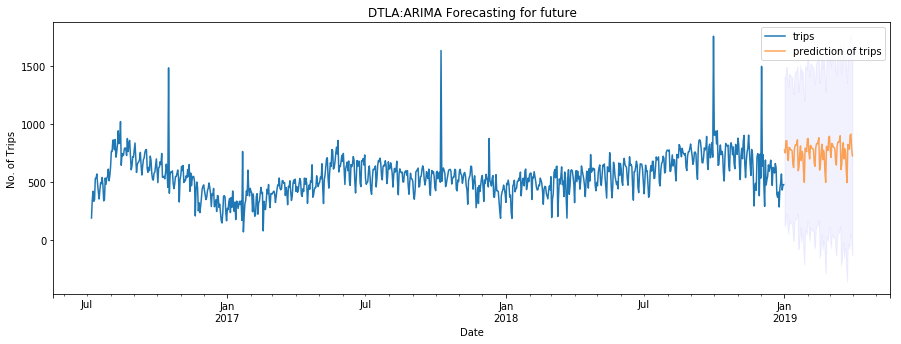

In [57]:
pred = results.get_prediction(start='2019-01-01', end='2019-03-31', dynamic=False)
pred_ci = pred.conf_int()
ax=Data_DTLA_D.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='prediction of trips', alpha=.7, figsize=(15,5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='b', alpha=0.05)

ax.set_xlabel('Date')
ax.set_ylabel('No. of Trips')
ax.set_title("DTLA:ARIMA Forecasting for future")
plt.legend()


In [50]:
#Actual number of trips for validation data
y_truth = Data_DTLA_D['2018-08-31':]
y_truth


,trips
start_time,
2018-08-31,828
2018-09-01,779
2018-09-02,727
2018-09-03,653
2018-09-04,678
2018-09-05,757
2018-09-06,759
2018-09-07,742
2018-09-08,594


In [47]:
#Predicted number of trips for validation data
y_future=pred.predicted_mean
y_future

2019-01-01    774.301700
2019-01-02    751.909059
2019-01-03    855.473845
2019-01-04    857.759455
2019-01-05    738.088055
2019-01-06    685.948508
2019-01-07    799.342262
2019-01-08    795.038717
2019-01-09    777.372607
2019-01-10    777.261998
2019-01-11    770.408960
2019-01-12    653.269913
2019-01-13    625.469988
2019-01-14    781.764265
2019-01-15    818.250171
2019-01-16    815.459843
2019-01-17    833.323861
2019-01-18    864.568767
2019-01-19    598.081474
2019-01-20    627.933757
2019-01-21    746.077349
2019-01-22    812.000555
2019-01-23    685.296631
2019-01-24    764.473248
2019-01-25    742.703849
2019-01-26    583.059415
2019-01-27    497.368762
2019-01-28    792.157699
2019-01-29    786.226466
2019-01-30    762.373174
                 ...    
2019-03-02    770.247615
2019-03-03    712.709795
2019-03-04    833.270540
2019-03-05    824.021610
2019-03-06    802.550174
2019-03-07    798.469476
2019-03-08    790.068484
2019-03-09    673.592687
2019-03-10    646.274389


In [51]:
#predicted  number of trips for nex  quarter
y_forecast=pred1.predicted_mean
y_forecast

2018-08-31    737.960465
2018-09-01    604.473863
2018-09-02    594.323959
2018-09-03    697.057615
2018-09-04    757.700900
2018-09-05    660.281757
2018-09-06    718.095211
2018-09-07    706.275628
2018-09-08    568.811652
2018-09-09    504.773086
2018-09-10    715.560061
2018-09-11    729.516487
2018-09-12    712.375279
2018-09-13    794.400933
2018-09-14    786.212921
2018-09-15    678.028309
2018-09-16    636.398487
2018-09-17    734.595500
2018-09-18    738.621436
2018-09-19    728.372799
2018-09-20    735.446861
2018-09-21    732.147905
2018-09-22    613.692658
2018-09-23    584.826918
2018-09-24    724.115827
2018-09-25    767.185206
2018-09-26    761.686460
2018-09-27    779.479593
2018-09-28    796.062072
2018-09-29    579.563970
                 ...    
2018-12-02    498.525889
2018-12-03    759.635737
2018-12-04    762.377030
2018-12-05    741.445022
2018-12-06    839.422950
2018-12-07    839.206733
2018-12-08    722.008416
2018-12-09    672.567996
2018-12-10    782.378225


In [563]:
# Calculating mean square error
mse = ((y_forecasted[:1] - y_truth[:1])/ y_truth[:1]).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is trips   -0.11
dtype: float64


Exporting this data file in Microsoft Excel to further analyze them.

In [52]:
y_forecast.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/DTLAforecast.xlsx')

In [582]:
y_truth.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/DTLAtruth.xlsx')

In [48]:
y_future.to_excel('C:/Users/saksh/Downloads/CoursesSpring19/Data Science Competition/for/DTLAfuture.xlsx')